In [93]:
using Random
using Distributions
using KernelDensity
include("../Inversion/AffineInvariantMCMC.jl")
include("../Inversion/GMNVI.jl")
include("../Inversion/GMWVI.jl")
include("../Inversion/Plot.jl")
include("../Inversion/DF_GMVI.jl")
include("../Inversion/GMBBVI.jl")
include("./MultiModal.jl")
Random.seed!(111);

## Gaussian likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
A \theta
+\eta \quad (A = I)
\qquad 
y = 
\begin{bmatrix}
0.0\\
1.0
\end{bmatrix} 
\qquad
\Sigma_{\eta} = I 
\end{align*}
$$


We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 

$$F(\theta) = \frac{y - A \theta}{\sigma_\eta}$$

     

## Circle shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\theta^T A \theta
+\eta \quad (A = I)
\qquad 
y = 1
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_\eta^2 
\end{bmatrix} 
\end{align*} (\sigma_\eta = 0.3)
$$


We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 

$$F(\theta) = \frac{y - \theta^T A \theta}{\sigma_\eta}$$

     
     
## Banana shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\begin{bmatrix}
\lambda(\theta_{(2)} -  \theta_{(1)}^2)\\
\theta_{(1)}
\end{bmatrix}
+\eta \quad (\lambda = 100)
\qquad 
y = 
\begin{bmatrix}
0\\
1
\end{bmatrix}
\qquad
\Sigma_{\eta} = 
\sigma_\eta^2 I \qquad (\sigma_\eta = 0.3)
\end{align*}
$$

We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 
$$F(\theta) = 
\begin{bmatrix}
\frac{y_{(1)} - \lambda(\theta_{(2)} -  \theta_{(1)}^2)}{\sigma_\eta}\\
\frac{y_{(2)} - \theta_{(1)}}{\sigma_\eta}
\end{bmatrix}$$
     
     
## Double banana shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\begin{bmatrix}
\log\Bigl(
\lambda(\theta_{(2)} -  \theta_{(1)}^2)^2 + (1 - \theta_{(1)})^2
\Bigr)\\ 
\theta_{(1)}\\ 
\theta_{(2)}
\end{bmatrix}
+ \eta \quad(\lambda = 100)
\qquad 
y = 
\begin{bmatrix}
\log(\lambda+1)\\
0\\
0
\end{bmatrix}
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_\eta^2 & \\
& 1^2   \\
& & 1^2
\end{bmatrix}  
\end{align*}
$$

We essentially focus on the prior $\mathcal{N}(0,I)$, and we are sampling 
$e^{-\frac{1}{2}F^TF}$ 
with 
$$F(\theta) = 
\begin{bmatrix}
\frac{y_{(1)} - \log\Bigl(
\lambda(\theta_{(2)} -  \theta_{(1)}^2)^2 + (1 - \theta_{(1)})^2
\Bigr)}{\sigma_\eta}\\
y_{(2)} - \theta_{(1)}\\
y_{(3)} - \theta_{(2)}
\end{bmatrix}$$

In [94]:
function visualization_comparison_100d(ax,  obj_DF_GMVI = nothing, obj_BBVI= nothing; Nx = 200, Ny = 200, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0],
    func_F = nothing, func_Phi = nothing, bandwidth=nothing, make_label::Bool=false, N_iter=500)
    
    x_min, x_max = x_lim
    y_min, y_max = y_lim
    boundary=((x_lim[1],x_lim[2]),(y_lim[1],y_lim[2]))

    xx = LinRange(x_min, x_max, Nx)
    yy = LinRange(y_min, y_max, Ny)
    dx, dy = xx[2] - xx[1], yy[2] - yy[1]
    X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)'

    Z_ref = (func_Phi === nothing ? posterior_2d(func_F, X, Y, "func_F") : posterior_2d(func_Phi, X, Y, "func_Phi"))
    color_lim = (minimum(Z_ref), maximum(Z_ref))
    ax[1].pcolormesh(X, Y, Z_ref, cmap="viridis", clim=color_lim)

    if obj_DF_GMVI!=nothing
        error = zeros(N_iter+1)
        last_n_iters = 10  #use the last "last_n_iters" iterations to draw pictures

        obj = obj_DF_GMVI
        for iter = 0:N_iter
            x_w = exp.(obj.logx_w[iter+1]); x_w /= sum(x_w)
            x_mean = obj.x_mean[iter+1][:,1:2]
            xx_cov = obj.xx_cov[iter+1][:,1:2,1:2]
            Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
            error[iter+1] = norm(Z - Z_ref,1)*dx*dy
            if iter == N_iter
            
                ax[2].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                ax[2].scatter([obj.x_mean[1][:,1];], [obj.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                ax[2].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)
            
            end
        end
        

        ax[5].semilogy(Array(0:N_iter), error, label="DF_GMVI") 
    end



    if obj_BBVI !=nothing
        error = zeros(length(obj_BBVI),N_iter+1)
        last_n_iters = 10  #use the last "last_n_iters" iterations to draw pictures

        for (i, obj) in enumerate(obj_BBVI)
            for iter = 0:N_iter
                x_w = exp.(obj.logx_w[iter+1]); x_w /= sum(x_w)
                x_mean = obj.x_mean[iter+1][:,1:2]
                xx_cov = obj.xx_cov[iter+1][:,1:2,1:2]
                Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
                error[i, iter+1] = norm(Z - Z_ref,1)*dx*dy
                if iter == N_iter
                
                    ax[i+2].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                    ax[i+2].scatter([obj.x_mean[1][:,1];], [obj.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                    ax[i+2].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)
                
                end
            end
        end
        label = ["J="*string(obj.N_ens)  for obj in obj_BBVI ]
        ax[5].semilogy(Array(0:N_iter), error', label=label) 
    end

    
      
    
    if make_label==true  ax[5].legend()  end

    ymin, ymax = ax[5].get_ylim()

    # Ensure the lower bound of y-ticks is below 0.1
    if ymin > 0.1 && ymin < 0.5
        ax[5].set_ylim(0.1, ymax)  # Set the lower limit to a value below 0.1
    end

end




visualization_comparison_100d (generic function with 3 methods)

# Test the aforementioned examples with different methods

[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("iter = ", 160, " / ", 200)
[ Info: ("iter = ", 180, " / ", 200)
[ Info: ("iter = ", 200, " / ", 200)
[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("iter = ", 160, " / ", 200)
[ Info: ("iter = ", 180, " / ", 200)
[ Info: ("iter = ", 200, " / ", 200)
[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("ite

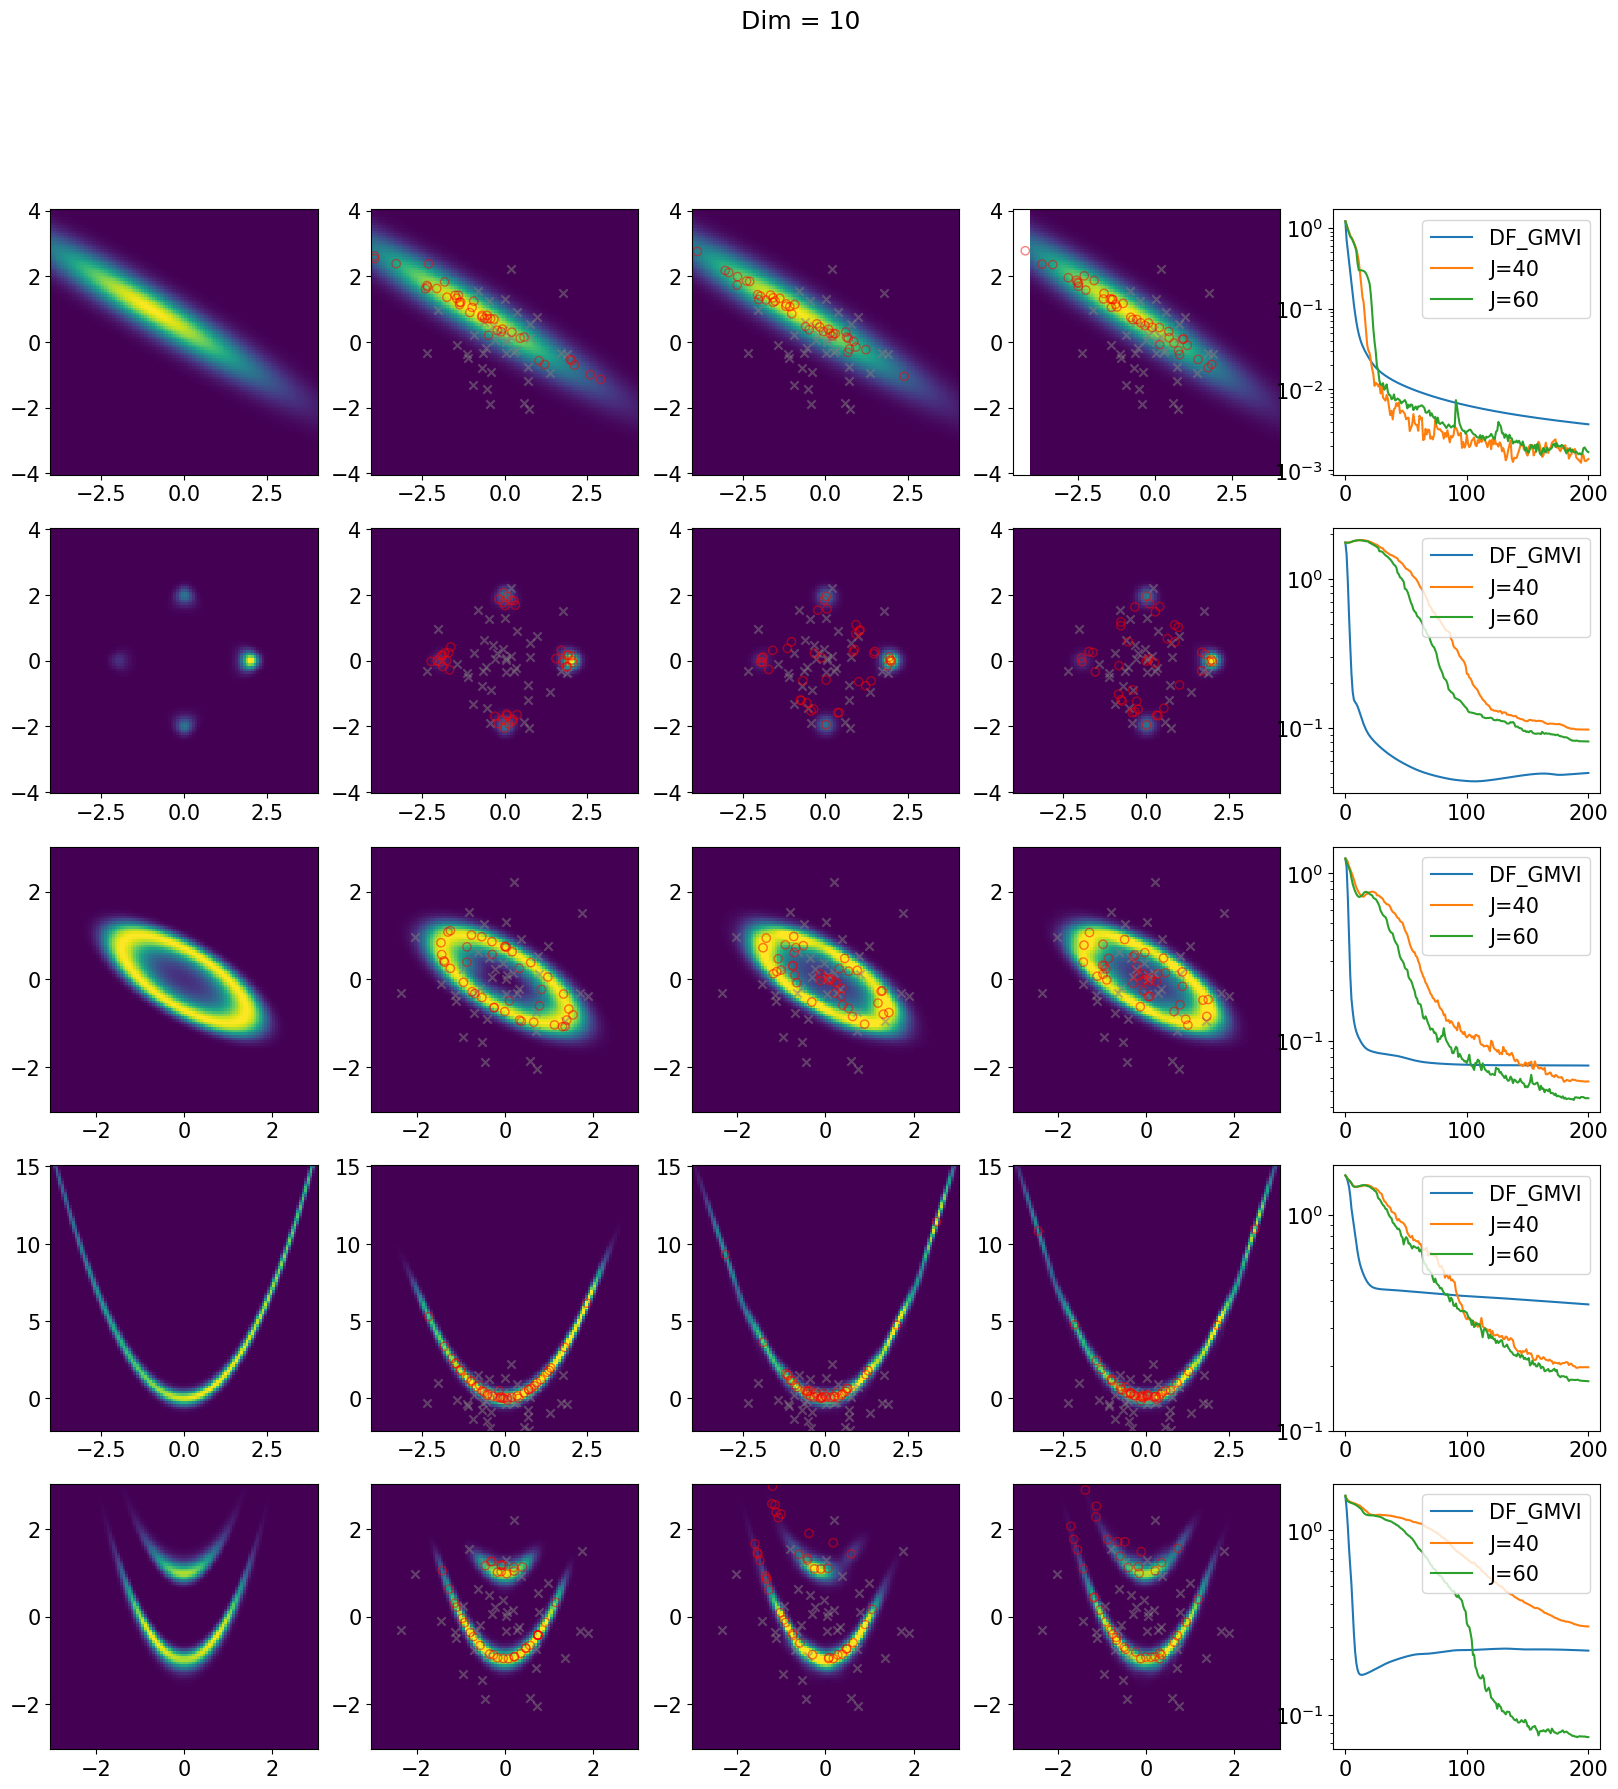

In [95]:
fig, ax = PyPlot.subplots(nrows=5, ncols=5, sharex=false, sharey=false, figsize=(20,20))
Random.seed!(111);
# Problem setup
N_iter = 200
Nx, Ny = 100, 100
N_x = 10
fig.suptitle("Dim = "*string(N_x))
N_modes = 40
x0_w  = ones(N_modes)/N_modes
N_ens_array = [4*N_x, 6*N_x]
N_ens_max = N_ens_array[end]
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
μ0, Σ0 = zeros(N_x), Diagonal(ones(N_x))
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end
dt = 0.5


Gtype = "Gaussian"
ση = 1.0
A = [1.0 1.0; 1.0 2.0]
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
# compute marginal distribution
func_marginal_args = (y[1:2], ση, A, Gtype)
func_marginal_F(x) = F(x, func_marginal_args)
func_Phi(x) = Phi(x, func_args)

t0 = time()
obj_DF_GMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1] 
t1  = time()
BBVI = [Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt, N_ens=N_ens)
        for N_ens in N_ens_array]
t2  = time()
@info "DF_GMVI time = ", t1 - t0, "BBVI time = ", t2 - t1
visualization_comparison_100d(ax[1, :], obj_DF_GMVI, BBVI; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-4.0, 4.0], func_F=func_F_marginal, 
    bandwidth=(0.32,0.22), make_label=true,  N_iter= N_iter)



Gtype = "Four_modes"
ση = 1.0
y = [4.2297; 4.2297; 0.5; 0.0; zeros(N_x-2)]
func_args = (y, ση, 0, Gtype)
func_marginal_args = (y[1:4], ση, 0, Gtype)
func_F(x) = F(x, func_args)
func_F_marginal(x) = F(x, func_marginal_args)
func_Phi(x) = Phi(x, func_args)

t0 = time()
obj_DF_GMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1] 
t1  = time()
BBVI = [Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt, N_ens=N_ens)
        for N_ens in N_ens_array]
t2  = time()
@info "DF_GMVI time = ", t1 - t0, "BBVI time = ", t2 - t1
visualization_comparison_100d(ax[2, :], obj_DF_GMVI, BBVI; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-4.0, 4.0], func_F=func_F_marginal, 
    bandwidth=(0.32,0.22), make_label=true,  N_iter= N_iter)



Gtype = "Circle"
ση = [0.5; ones(N_x-2)]
A = [1.0 1.0; 1.0 2.0]
y = [1.0; zeros(N_x-2)]
func_args = (y, ση, A , Gtype)
func_marginal_args = (y[1:1], ση[1:1], A , Gtype)
func_F(x) = F(x, func_args)
func_F_marginal(x) = F(x, func_marginal_args)
func_Phi(x) = Phi(x, func_args)

t0 = time()
obj_DF_GMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1] 
t1  = time()
BBVI = [Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt, N_ens=N_ens)
        for N_ens in N_ens_array]
t2  = time()
@info "DF_GMVI time = ", t1 - t0, "BBVI time = ", t2 - t1
visualization_comparison_100d(ax[3, :], obj_DF_GMVI, BBVI; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F_marginal, 
    bandwidth=(0.32,0.22), make_label=true,  N_iter= N_iter)



Gtype = "Banana"
ση = [sqrt(10.0); sqrt(10.0); ones(N_x-2)]
λ = 10.0
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, λ , Gtype)
func_marginal_args = (y[1:2], ση[1:2], λ, Gtype)
func_F(x) = F(x, func_args)
func_F_marginal(x) = F(x, func_marginal_args)
func_Phi(x) = Phi(x, func_args)

t0 = time()
obj_DF_GMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1] 
t1  = time()
BBVI = [Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt, N_ens=N_ens)
        for N_ens in N_ens_array]
t2  = time()
@info "DF_GMVI time = ", t1 - t0, "BBVI time = ", t2 - t1
visualization_comparison_100d(ax[4, :], obj_DF_GMVI, BBVI; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-2.0, 15.0], func_F=func_F_marginal, 
    bandwidth=(0.32,0.22), make_label=true,  N_iter= N_iter)




Gtype = "Double_banana"
ση = [0.3; 1.0; 1.0; ones(N_x-2)]
λ = 100.0
y = [log(λ+1); 0.0; 0.0; zeros(N_x-2)]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_marginal_args = (y[1:3], ση[1:3], λ , Gtype)
func_F(x) = F(x, func_args)
func_F_marginal(x) = F(x, func_marginal_args)
func_Phi(x) = Phi(x, func_args)

t0 = time()
obj_DF_GMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1] 
t1  = time()
BBVI = [Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt, N_ens=N_ens)
        for N_ens in N_ens_array]
t2  = time()
@info "DF_GMVI time = ", t1 - t0, "BBVI time = ", t2 - t1
visualization_comparison_100d(ax[5, :], obj_DF_GMVI, BBVI; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F_marginal, 
    bandwidth=(0.32,0.22), make_label=true,  N_iter= N_iter)


[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("iter = ", 160, " / ", 200)
[ Info: ("iter = ", 180, " / ", 200)
[ Info: ("iter = ", 200, " / ", 200)
[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("iter = ", 160, " / ", 200)
[ Info: ("iter = ", 180, " / ", 200)
[ Info: ("iter = ", 200, " / ", 200)
[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("ite

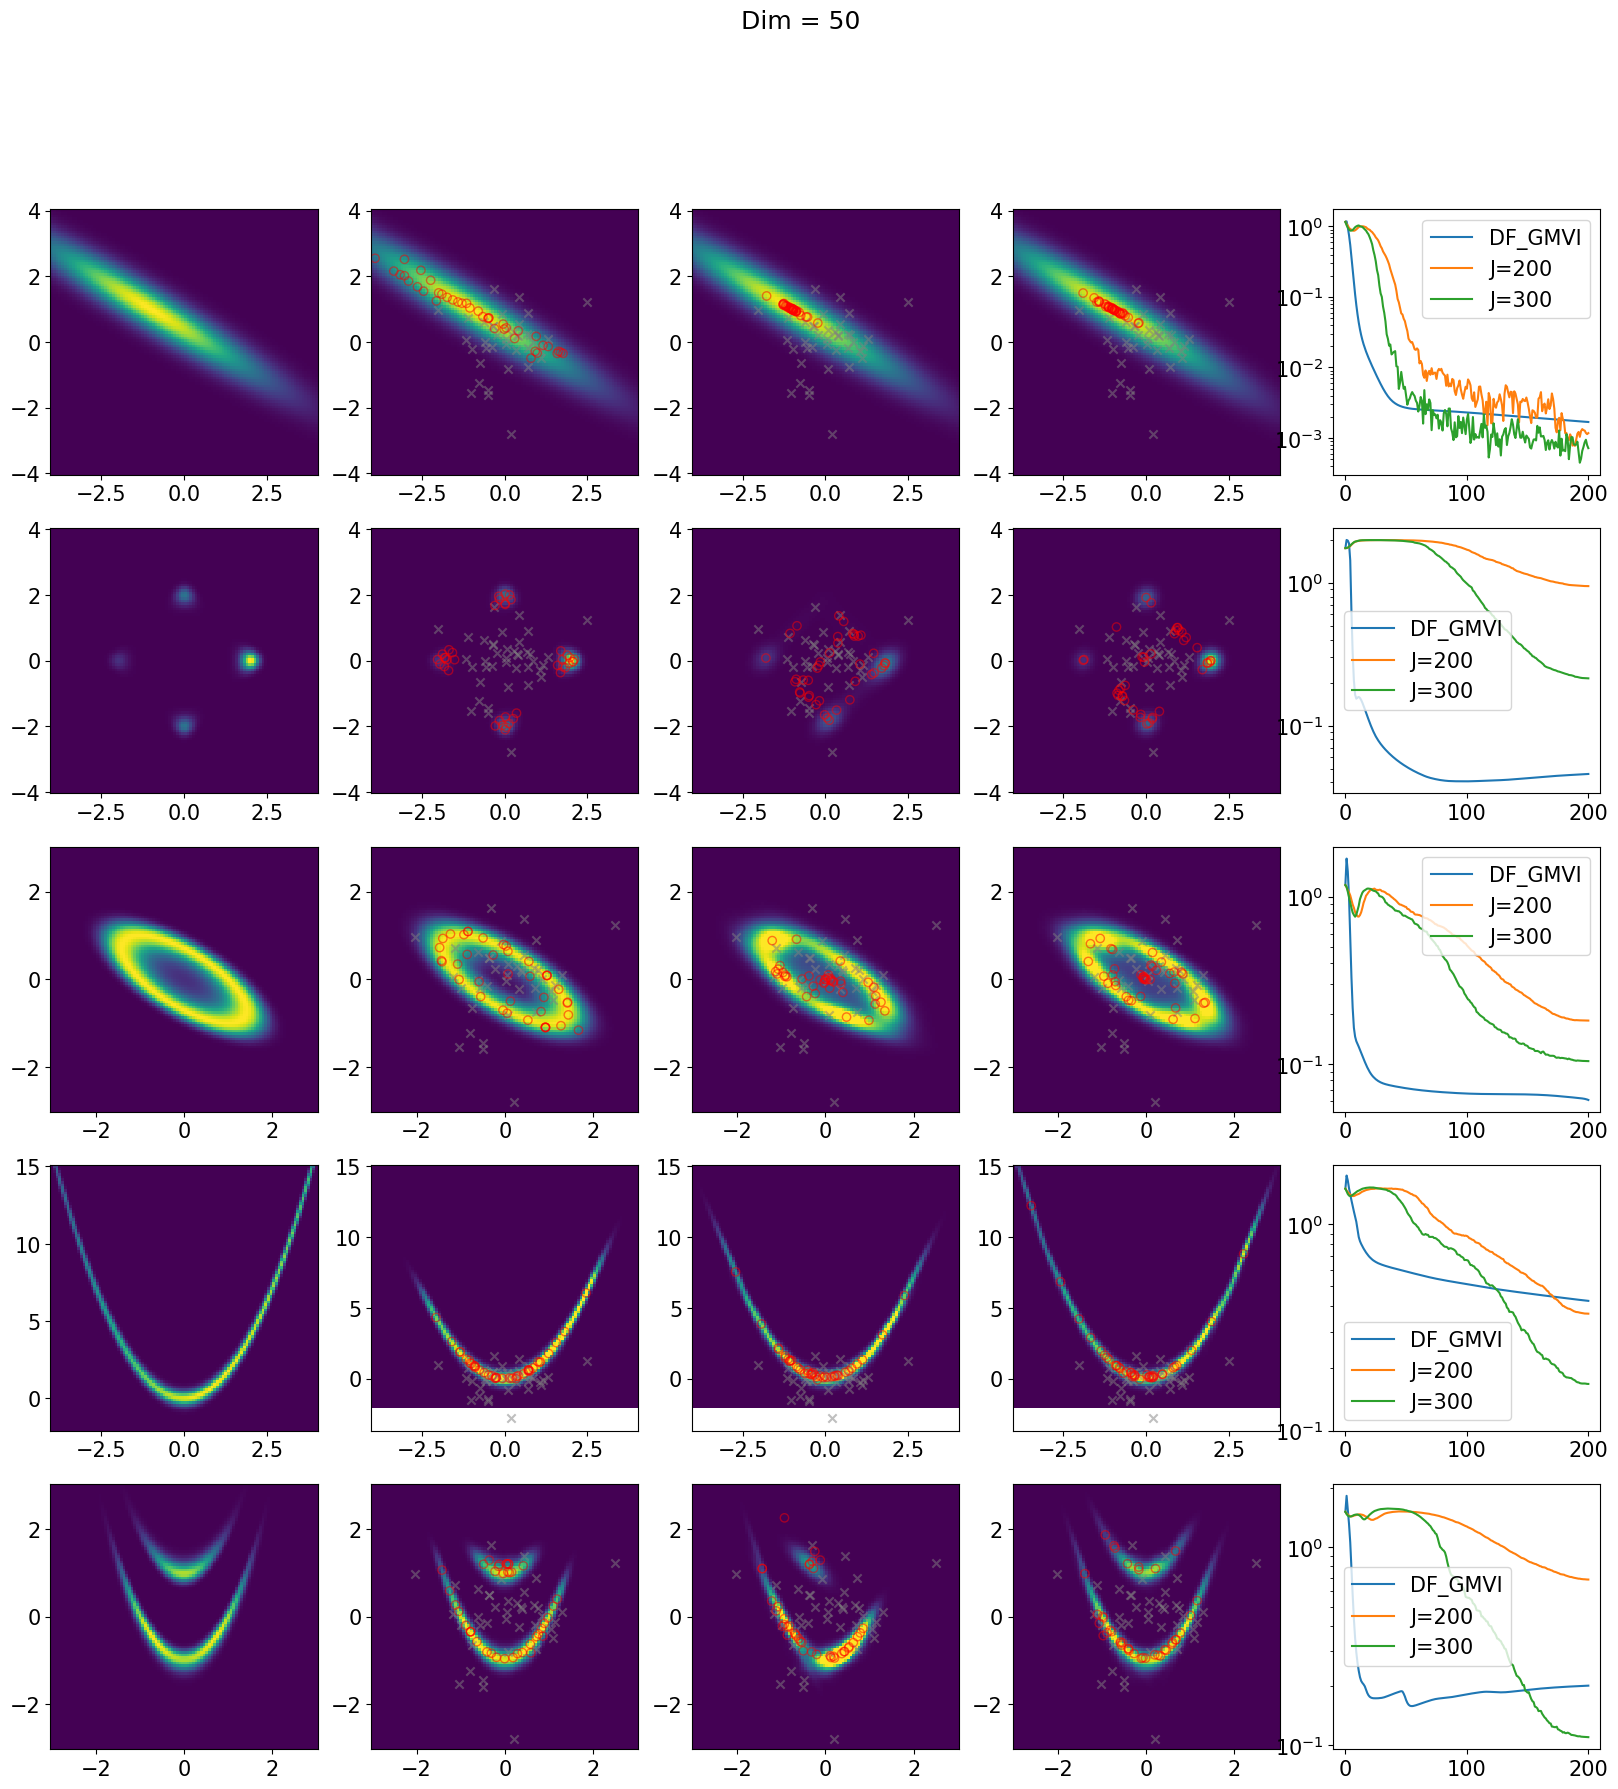

In [96]:
fig, ax = PyPlot.subplots(nrows=5, ncols=5, sharex=false, sharey=false, figsize=(20,20))
Random.seed!(111);
# Problem setup
N_iter = 200
Nx, Ny = 100, 100
N_x = 50
fig.suptitle("Dim = "*string(N_x))
N_modes = 40
x0_w  = ones(N_modes)/N_modes
N_ens_array = [4*N_x, 6*N_x]
N_ens_max = N_ens_array[end]
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
μ0, Σ0 = zeros(N_x), 1*Diagonal(ones(N_x))
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end
dt = 0.5


Gtype = "Gaussian"
ση = 1.0
A = [1.0 1.0; 1.0 2.0]
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
# compute marginal distribution
func_marginal_args = (y[1:2], ση, A, Gtype)
func_marginal_F(x) = F(x, func_marginal_args)
func_Phi(x) = Phi(x, func_args)

t0 = time()
obj_DF_GMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1] 
t1  = time()
BBVI = [Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt, N_ens=N_ens)
        for N_ens in N_ens_array]
t2  = time()
@info "DF_GMVI time = ", t1 - t0, "BBVI time = ", t2 - t1
visualization_comparison_100d(ax[1, :], obj_DF_GMVI, BBVI; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-4.0, 4.0], func_F=func_F_marginal, 
    bandwidth=(0.32,0.22), make_label=true,  N_iter= N_iter)



Gtype = "Four_modes"
ση = 1.0
y = [4.2297; 4.2297; 0.5; 0.0; zeros(N_x-2)]
func_args = (y, ση, 0, Gtype)
func_marginal_args = (y[1:4], ση, 0, Gtype)
func_F(x) = F(x, func_args)
func_F_marginal(x) = F(x, func_marginal_args)
func_Phi(x) = Phi(x, func_args)

obj_DF_GMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1] 
BBVI = [Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt, N_ens=N_ens)
        for N_ens in N_ens_array]
visualization_comparison_100d(ax[2, :], obj_DF_GMVI, BBVI; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-4.0, 4.0], func_F=func_F_marginal, 
    bandwidth=(0.32,0.22), make_label=true,  N_iter= N_iter)



Gtype = "Circle"
ση = [0.5; ones(N_x-2)]
A = [1.0 1.0; 1.0 2.0]
y = [1.0; zeros(N_x-2)]
func_args = (y, ση, A , Gtype)
func_marginal_args = (y[1:1], ση[1:1], A , Gtype)
func_F(x) = F(x, func_args)
func_F_marginal(x) = F(x, func_marginal_args)
func_Phi(x) = Phi(x, func_args)

t0 = time()
obj_DF_GMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1] 
t1  = time()
BBVI = [Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt, N_ens=N_ens)
        for N_ens in N_ens_array]
t2  = time()
@info "DF_GMVI time = ", t1 - t0, "BBVI time = ", t2 - t1
visualization_comparison_100d(ax[3, :], obj_DF_GMVI, BBVI; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F_marginal, 
    bandwidth=(0.32,0.22), make_label=true,  N_iter= N_iter)



Gtype = "Banana"
ση = [sqrt(10.0); sqrt(10.0); ones(N_x-2)]
λ = 10.0
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, λ , Gtype)
func_marginal_args = (y[1:2], ση[1:2], λ, Gtype)
func_F(x) = F(x, func_args)
func_F_marginal(x) = F(x, func_marginal_args)
func_Phi(x) = Phi(x, func_args)

t0 = time()
obj_DF_GMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1] 
t1  = time()
BBVI = [Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt, N_ens=N_ens)
        for N_ens in N_ens_array]
t2  = time()
@info "DF_GMVI time = ", t1 - t0, "BBVI time = ", t2 - t1
visualization_comparison_100d(ax[4, :], obj_DF_GMVI, BBVI; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-2.0, 15.0], func_F=func_F_marginal, 
    bandwidth=(0.32,0.22), make_label=true,  N_iter= N_iter)




Gtype = "Double_banana"
ση = [0.3; 1.0; 1.0; ones(N_x-2)]
λ = 100.0
y = [log(λ+1); 0.0; 0.0; zeros(N_x-2)]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_marginal_args = (y[1:3], ση[1:3], λ , Gtype)
func_F(x) = F(x, func_args)
func_F_marginal(x) = F(x, func_marginal_args)
func_Phi(x) = Phi(x, func_args)

t0 = time()
obj_DF_GMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1] 
t1  = time()
BBVI = [Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt, N_ens=N_ens)
        for N_ens in N_ens_array]
t2  = time()
@info "DF_GMVI time = ", t1 - t0, "BBVI time = ", t2 - t1
visualization_comparison_100d(ax[5, :], obj_DF_GMVI, BBVI; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F_marginal, 
    bandwidth=(0.32,0.22), make_label=true,  N_iter= N_iter)


[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("iter = ", 160, " / ", 200)
[ Info: ("iter = ", 180, " / ", 200)
[ Info: ("iter = ", 200, " / ", 200)
[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("iter = ", 160, " / ", 200)
[ Info: ("iter = ", 180, " / ", 200)
[ Info: ("iter = ", 200, " / ", 200)
[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("ite

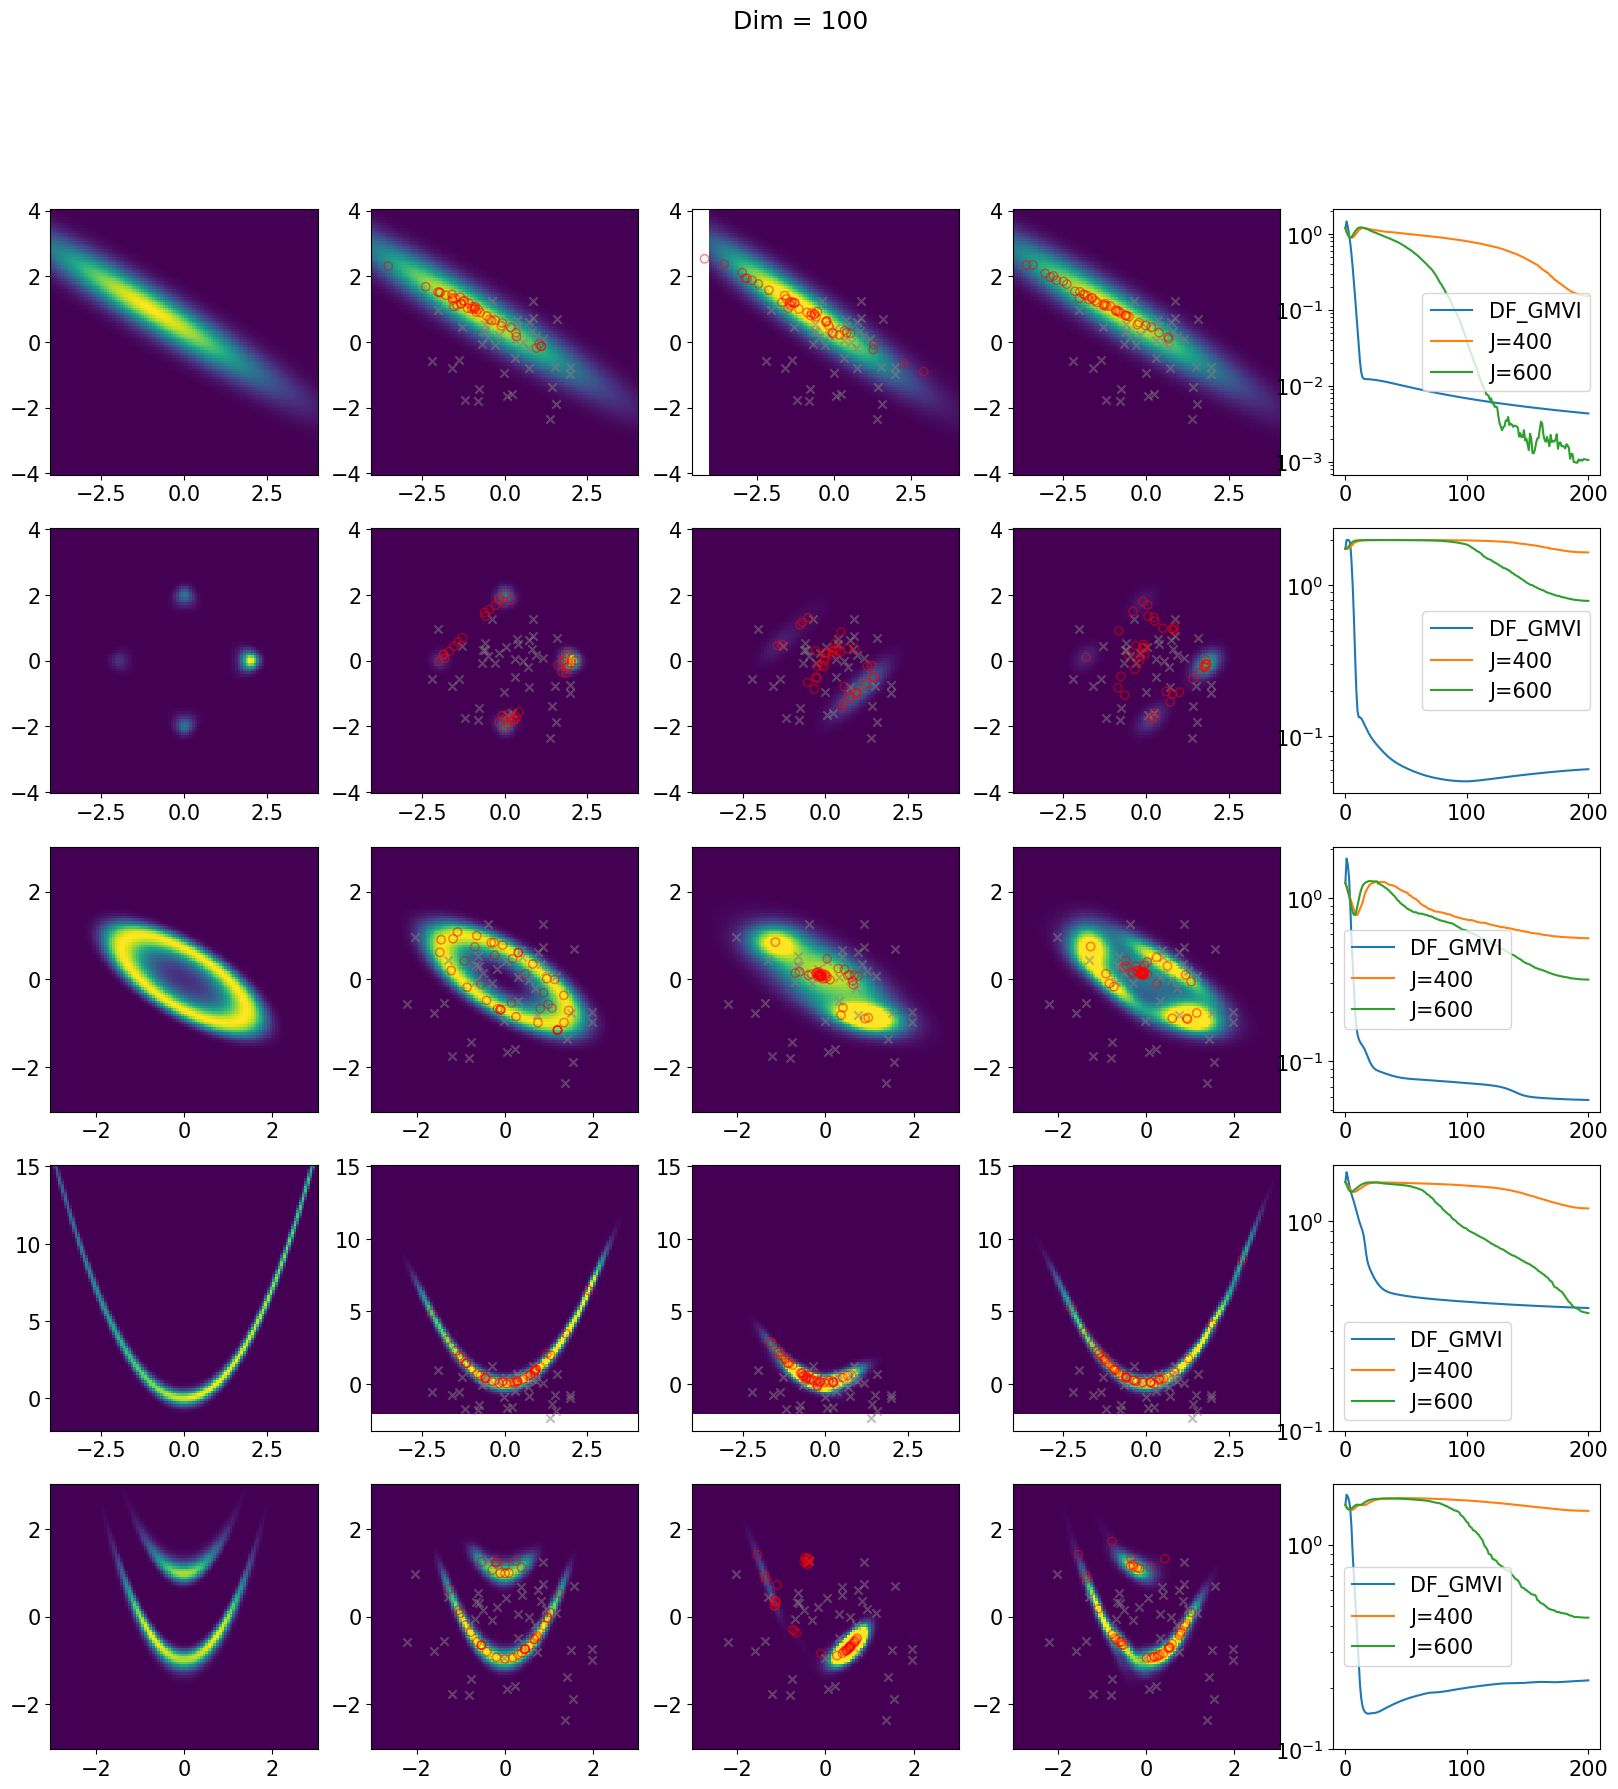

(0.1, 1.981673868009243)

In [97]:
fig, ax = PyPlot.subplots(nrows=5, ncols=5, sharex=false, sharey=false, figsize=(20,20))
Random.seed!(111);
# Problem setup
N_iter = 200
Nx, Ny = 100, 100
N_x = 100
fig.suptitle("Dim = "*string(N_x))
N_modes = 40
x0_w  = ones(N_modes)/N_modes
N_ens_array = [4*N_x, 6*N_x]
N_ens_max = N_ens_array[end]
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
μ0, Σ0 = zeros(N_x), 1*Diagonal(ones(N_x))
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end
dt = 0.5


Gtype = "Gaussian"
ση = 1.0
A = [1.0 1.0; 1.0 2.0]
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
# compute marginal distribution
func_marginal_args = (y[1:2], ση, A, Gtype)
func_marginal_F(x) = F(x, func_marginal_args)
func_Phi(x) = Phi(x, func_args)

t0 = time()
obj_DF_GMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1] 
t1  = time()
BBVI = [Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt, N_ens=N_ens)
        for N_ens in N_ens_array]
t2  = time()
@info "DF_GMVI time = ", t1 - t0, "BBVI time = ", t2 - t1
visualization_comparison_100d(ax[1, :], obj_DF_GMVI, BBVI; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-4.0, 4.0], func_F=func_F_marginal, 
    bandwidth=(0.32,0.22), make_label=true,  N_iter= N_iter)



Gtype = "Four_modes"
ση = 1.0
y = [4.2297; 4.2297; 0.5; 0.0; zeros(N_x-2)]
func_args = (y, ση, 0, Gtype)
func_marginal_args = (y[1:4], ση, 0, Gtype)
func_F(x) = F(x, func_args)
func_F_marginal(x) = F(x, func_marginal_args)
func_Phi(x) = Phi(x, func_args)

obj_DF_GMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1] 
BBVI = [Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt, N_ens=N_ens)
        for N_ens in N_ens_array]
visualization_comparison_100d(ax[2, :], obj_DF_GMVI, BBVI; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-4.0, 4.0], func_F=func_F_marginal, 
    bandwidth=(0.32,0.22), make_label=true,  N_iter= N_iter)



Gtype = "Circle"
ση = [0.5; ones(N_x-2)]
A = [1.0 1.0; 1.0 2.0]
y = [1.0; zeros(N_x-2)]
func_args = (y, ση, A , Gtype)
func_marginal_args = (y[1:1], ση[1:1], A , Gtype)
func_F(x) = F(x, func_args)
func_F_marginal(x) = F(x, func_marginal_args)
func_Phi(x) = Phi(x, func_args)

t0 = time()
obj_DF_GMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1] 
t1  = time()
BBVI = [Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt, N_ens=N_ens)
        for N_ens in N_ens_array]
t2  = time()
@info "DF_GMVI time = ", t1 - t0, "BBVI time = ", t2 - t1
visualization_comparison_100d(ax[3, :], obj_DF_GMVI, BBVI; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F_marginal, 
    bandwidth=(0.32,0.22), make_label=true,  N_iter= N_iter)



Gtype = "Banana"
ση = [sqrt(10.0); sqrt(10.0); ones(N_x-2)]
λ = 10.0
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, λ , Gtype)
func_marginal_args = (y[1:2], ση[1:2], λ, Gtype)
func_F(x) = F(x, func_args)
func_F_marginal(x) = F(x, func_marginal_args)
func_Phi(x) = Phi(x, func_args)

t0 = time()
obj_DF_GMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1] 
t1  = time()
BBVI = [Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt, N_ens=N_ens)
        for N_ens in N_ens_array]
t2  = time()
@info "DF_GMVI time = ", t1 - t0, "BBVI time = ", t2 - t1
visualization_comparison_100d(ax[4, :], obj_DF_GMVI, BBVI; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-2.0, 15.0], func_F=func_F_marginal, 
    bandwidth=(0.32,0.22), make_label=true,  N_iter= N_iter)




Gtype = "Double_banana"
ση = [0.3; 1.0; 1.0; ones(N_x-2)]
λ = 100.0
y = [log(λ+1); 0.0; 0.0; zeros(N_x-2)]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_marginal_args = (y[1:3], ση[1:3], λ , Gtype)
func_F(x) = F(x, func_args)
func_F_marginal(x) = F(x, func_marginal_args)
func_Phi(x) = Phi(x, func_args)

t0 = time()
obj_DF_GMVI = Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1] 
t1  = time()
BBVI = [Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt, N_ens=N_ens)
        for N_ens in N_ens_array]
t2  = time()
@info "DF_GMVI time = ", t1 - t0, "BBVI time = ", t2 - t1
visualization_comparison_100d(ax[5, :], obj_DF_GMVI, BBVI; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F_marginal, 
    bandwidth=(0.32,0.22), make_label=true,  N_iter= N_iter)
